# Metoda konečných prvků a knihovna FEniCS
Knihovna [FEniCS](https://fenicsproject.org) umožňuje snadnou implementaci metody konečných prvků a dalších numerických metod pro řešení parciálních diferenciálních rovnic.
Jádrem je modul __dolfin__ obsahující podporu pro triangulace, konečné prvky a formy.
Typická struktura programu je následující:
1. vytvoření nebo načtení triangulace a popis regionů v oblasti a na hranici
2. definice konečného prvku a konečněprvkového prostoru
3. definice forem pro slabou formulaci a okrajových podmínek
4. výpočet řešení
5. uložení a vizualizace řešení

Tyto kroky jsou ve FEniCS realizovány vysokoúrovňovými funkcemi.
Odkaz na dokumentaci API pro Python: https://fenicsproject.org/olddocs/dolfin/latest/python/

## Příklad: Potenciální proudění kolem válce
### Zadání:
Výše uvedený postup si ukážeme na úloze proudění vzduchu okolo válce s poloměrem 10 cm.
Uvažujme čtvercovou oblast $1\times 1$ m, tj. $\Omega=(0,1)\times(0,1)$, okolo kruhového průřezu válce $B=\{x\in\mathbb R^2;(x_1-0.5)^2+(x_2-0.5)^2\le 0.1^2\}. $
Na levé straně čtverce je vstupní rychlost proudění $v_{in}=1~m/s$, zatímco na povrchu válce předpokládáme nulovou tečnou rychlost.
Rychlostní pole potenciálního proudění je dáno vztahem
$ \mathbf v=-\nabla\psi, $
kde $\psi$ je řešení Poissonovy úlohy:
$$ -\Delta \psi = 0 \mbox{ v }\Omega\setminus B $$
s okrajovou podmínkou
$$ \nabla\psi\cdot\mathbf n = \begin{cases}v_{in} & \mbox{ na }\Gamma_4:=\{0\}\times(0,1)\\0 & \mbox{ na }\partial B.\end{cases} $$
Dále předpokládáme nulový potenciál na pravé straně čtverce:
$$ \psi = 0 \mbox{ na }\Gamma_2:=\{1\}\times(0,1). $$
Spočteme řešení pomocí MKP a vyčíslíme odporovou sílu
$$ \mathbf f = \frac\varrho2\int_{\partial B}|\mathbf v|^2\mathbf n,\quad\varrho=1.225~kg/m^3. $$

### 1. Triangulace a popis oblasti
Nejprve definujeme triangulaci oblasti a popis hranice. Pro jednoduchá geometrie jako obdélník nebo kvádr umí FEniCS vygenerovat strukturovanou síť.
Komplikovanější oblasti, jako je ta naše, je třeba vysíťovat v externím nástroji a převést do formátu XML. Pro názornost si triangulaci zobrazíme:

In [ ]:
from dolfin import *
from matplotlib import pyplot as plt

# nacteni site
mesh = Mesh('square-without-circle.xml')

# nacteni popisku hranice
# (bc_regions: 1 = bottom, 2 = right, 3 = top, 4 = left, 5 = circle)
bc_regions = MeshFunction("size_t", mesh, "square-without-circle_facet_region.xml")

# inicializace objektu pro vypocet hranicnich integralu
ds = Measure("ds")(subdomain_data=bc_regions)

plot(mesh)

### 2. Prostor funkcí a okrajová podmínka
Dále definujeme konečněprvkový prostor funkcí a Dirichletovu okrajovou podmínku:

In [2]:
r = 2 # stupen polynomu
# prostor pro potencial
V = FunctionSpace(mesh, 'CG', r) # CG=spojite po castech polynomialni funkce

# prostor pro rychlost (stupen polynomu o 1 mensi
VV = VectorFunctionSpace(mesh, 'DG', r-1) # DG=nespojite funkce
bcs = [
       DirichletBC(V, Constant(0), bc_regions, 2) # nastavi hodnotu 0 na bc_region 2
      ]

### 3. Parametry modelu a slabá formulace
Slabá formulace: Hledáme $\psi\in V$ tak, aby pro libovolné $w\in V$ platilo:
$$ \int_{\Omega\setminus B} \nabla\psi\cdot\nabla w = \int_{\Gamma_4} v_{in} w. $$
Zde $V$ je prostor funkcí s integrovatelnými derivacemi prvního řádu a s hodnotou $0$ na $\Gamma_2$.

In [3]:
# rychlost na vstupu
v_in = Constant(1)

# objekt pro slabe reseni
psi = TrialFunction(V)
# objekt pro testovaci funkci
w   = TestFunction(V)
# formy pro slabou formulaci
a = dot(grad(psi), grad(w))*dx # dx="objemovy" integral
l = v_in*w*ds(4)

### 4. Vyřešení problému

In [4]:
# objekt pro uložení řešení
potential = Function(V)
potential.rename('potential', 'psi')

# řešení lineárního problému s okrajovými podmínkami
solve(a == l, potential, bcs)

# výpočet rychlostního pole (projekce gradientu psí na prostor VV)
velocity = project(-grad(potential), VV)
velocity.rename('velocity', 'v')

Solving linear variational problem.


### 5. Postprocessing
Řešení vykreslíme, uložíme pro pozdější zpracování a následně ještě spočteme odporovou sílu.

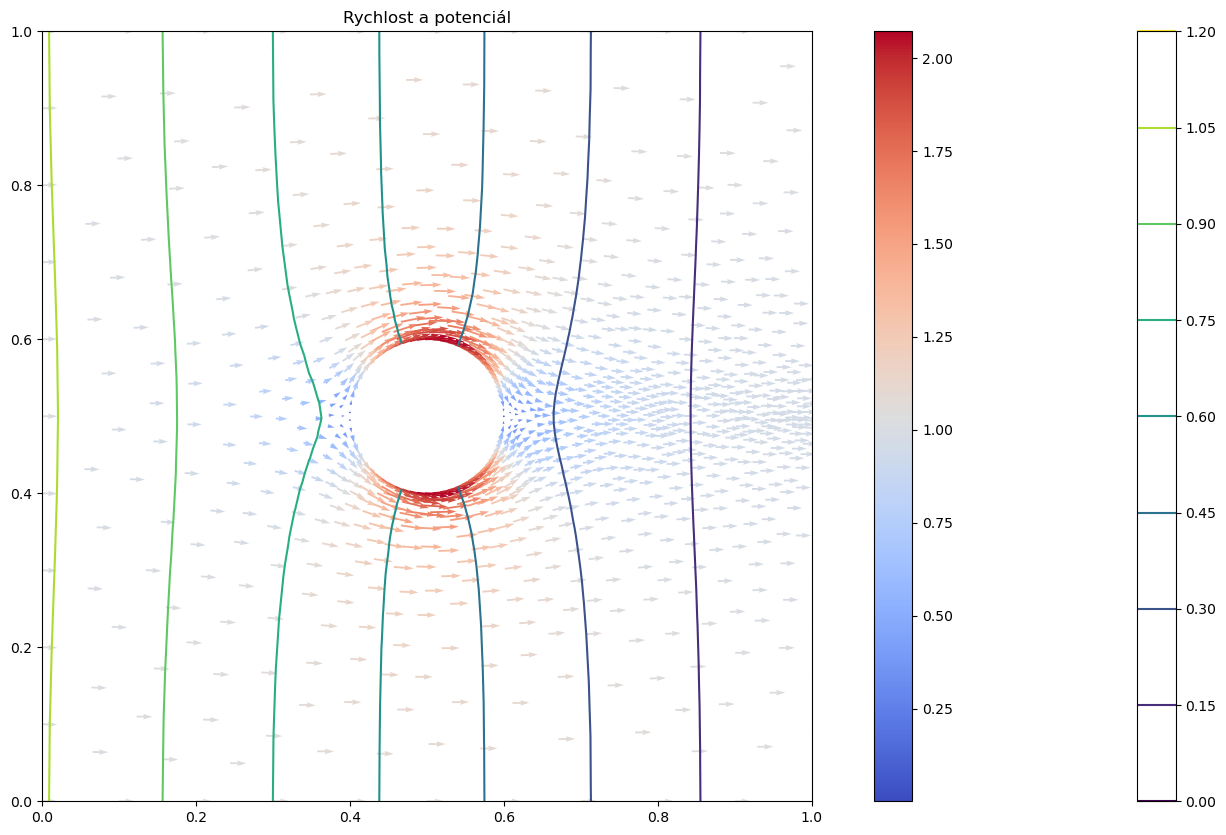

odporova sila = (7.528613e-04, 2.971886e-06)


In [5]:
# zobrazení potenciálu
plt.figure(figsize=(20,10))
c = plot(potential, mode='contour')
plt.colorbar(c)

# zobrazení rychlosti
c = plot(velocity, scale=50, title="Rychlost a potenciál")
c.set_cmap('coolwarm')
plt.colorbar(c)
plt.show()

# uložení řešení do PVD/VTK souboru pro další zpracování např. v ParaView
File('results/cfd-4-potential.pvd') << potential
File('results/cfd-4-velocity.pvd') << velocity

# 
n = FacetNormal(mesh) # normalovy vektor
rho = 1.225
fx = rho/2*assemble(dot(velocity,velocity)*dot(n,Constant((1,0)))*ds(5))
fy = rho/2*assemble(dot(velocity,velocity)*dot(n,Constant((0,1)))*ds(5))
print('odporova sila = ({:e}, {:e})'.format(fx, fy))

## Úloha 1 - vedení tepla
V návaznosti na předchozı́ úlohu uvažujte stacionárnı́ transport tepla s teplotou vzduchu na vstupu $\vartheta=0^\circ C$ a na povrchu válce $\vartheta = 20^\circ C$.
Uvažujte nejprve koeficient tepelné vodivosti $\alpha = 1~m^2/s$, a poté realistickou hodnotu $\alpha = k/(\varrho c_V)$, kde $k = 0.025~W/(m.K)$ a $c_V = 717~J/(kg.K)$.
1. Odvod’te klasickou a slabou formulaci.

Vaše odpověď
* klasická formulace (rovncie vedení tepla + okrajové podmínky)
$$ \nabla\cdot(\mathbf v\vartheta - \alpha\nabla\vartheta) = 0 \mbox{ v }\Omega\setminus B, $$
$$ \vartheta = \begin{cases}0 & \mbox{ na }\Gamma_4,\\20 & \mbox{ na }\partial B.\end{cases} $$
* slabá formulace (ve tvaru $a(\vartheta,w) = l(w)$)
$$ a(\vartheta,w) := \int_{\Omega\setminus B}\left(\nabla\cdot(\mathbf v\vartheta)w + \alpha\nabla\vartheta\cdot\nabla w\right) = 0 =: l(w). $$

2. Řešte pomocı́ MKP pro hodnotu $\alpha=1$.

Solving linear variational problem.


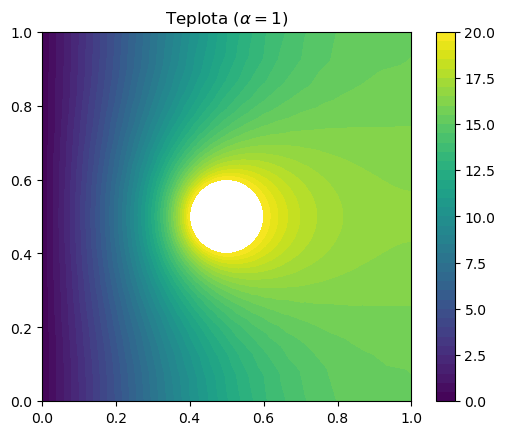

In [10]:
# prostor pro teplotu
Vtheta = FunctionSpace(mesh, 'CG', 1)

# parametry modelu
alpha = Constant(1)
phi_in = Constant(0)
phi_wall = Constant(20)
heat_source = Constant(0)

# okrajove podminky
bcs = [
       DirichletBC(Vtheta, phi_in, bc_regions, 4),
       DirichletBC(Vtheta, phi_wall, bc_regions, 5)
      ]


# formy pro slabou formulaci
theta = TrialFunction(Vtheta)
w = TestFunction(Vtheta)
a = (alpha*dot(grad(theta),grad(w)) + div(velocity*theta)*w)*dx
l = heat_source*w*dx

# vyreseni problemu
temperature = Function(Vtheta)
temperature.rename('temperature', 'c')
solve( a == l, temperature, bcs )

# vykresleni
c = plot(temperature, title='Teplota ($\\alpha=1$)')
plt.colorbar(c)
plt.show()


3. Nyní vyřešte pro realistickou hodnotu tepelné vodivosti. Ve vypočteném teplotním poli by měly být viditelné nefyzikální oscilace.

Solving linear variational problem.


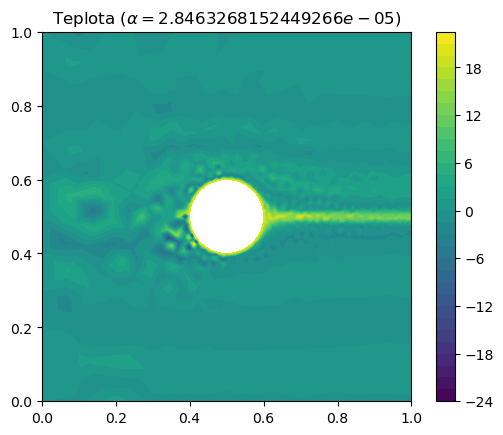

In [11]:
# aktualizace formy a
k = 0.025
cV = 717
alpha = Constant(k/(rho*cV))
a = (alpha*dot(grad(theta),grad(w)) + div(velocity*theta)*w)*dx

# vyreseni problemu
solve( a == l, temperature, bcs )

# vykresleni
c = plot(temperature, title='Teplota ($\\alpha='+str(k/(rho*cV))+'$)')
plt.colorbar(c)
plt.show()


3. Řešte pomocí MKP s SUPG stabilizacı́.
Metoda SUPG (streamline upwind Petrov-Galerkin) vychází z upravené slabé formulace:
$$ \forall w\in V:~a_{SUPG}(\vartheta,w) = l_{SUPG}(w), $$
kde
$$ a_{SUPG}(\vartheta,w) = a(\vartheta,w) + \int_{\Omega\setminus B} \tau(\mbox{levá strana klasické formulace})\nabla\cdot(\mathbf v w), \qquad \mbox{resp.} \qquad l_{SUPG}(w) = l(w) + \int_{\Omega\setminus B} \tau(\mbox{pravá strana klasické formulace})\nabla\cdot(\mathbf v w), $$
$$ \tau = \frac{h}{\|\mathbf v\|\xi\left(\tfrac{\|\mathbf v\|h}{2\alpha}\right)},\qquad \|\mathbf v\|=\max_{x\in\Omega\setminus B}|\mathbf v(x)|,\qquad \xi(t)=\frac{1+e^{-2t}}{1-e^{-2t}} - \frac1t. $$

Solving linear variational problem.


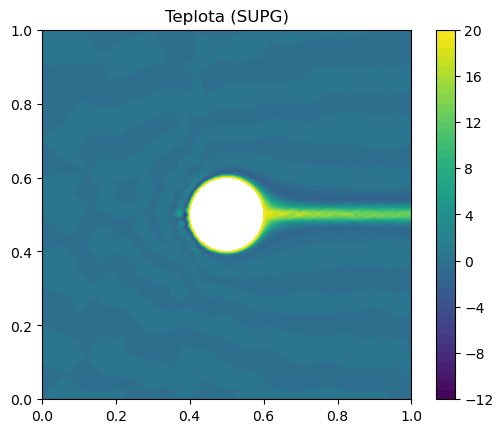

In [14]:
# SUPG stabilizace
h = CellDiameter(mesh)
def xi(x):
  return (1+exp(-2*x))/(1-exp(-2*x)) - 1/x
vnorm = norm(velocity.vector(),'linf')
tau = h/(2*vnorm)*(xi(vnorm*h/(2*alpha)))
a_supg = a + tau*(-div(alpha*grad(theta)) + div(velocity*theta))*div(velocity*w)*dx
l_supg = l + tau*heat_source*div(velocity*w)*dx

# vyreseni
temperature_supg = Function(Vtheta)
temperature_supg.rename('temperature', 'c')
solve( a_supg == l_supg, temperature_supg, bcs )

# vykresleni
c = plot(temperature_supg, title='Teplota (SUPG)')
plt.colorbar(c)
plt.show()
